# **Part A**
Count / Frequency based Naive Bayes Classifier

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO Steps Completed:
# 1. Fit method: log priors + log likelihoods (Laplace smoothing)
# 2. Predict method: compute total log probability per class, pick argmax
# 3. Other TODOs to be done in later notebook cells (data loading, vectorizer, etc.)
# =======================================================

def load_pubmed_rct_file(filepath):
    """Reads a .txt file from the PubMed 20k RCT dataset and returns a DataFrame."""
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


class NaiveBayesClassifier:
    """
    Custom Multinomial Naive Bayes Classifier (Scratch Implementation)
    Supports CountVectorizer or TF-IDF style sparse matrices.
    """

    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocab_size = 0

    def fit(self, X_counts, y):
        """Estimate priors and conditional likelihoods from training data."""
        y_arr = np.array(y)
        self.classes = np.unique(y_arr)
        self.vocab_size = X_counts.shape[1]

        total_samples = len(y_arr)

        for cls in self.classes:
            # Extract samples belonging to class 'cls'
            X_cls = X_counts[y_arr == cls]

            # --- Log Prior ---
            # P(cls) = (#docs in class) / (total docs)
            class_prob = X_cls.shape[0] / total_samples
            self.class_priors[cls] = np.log(class_prob + 1e-12)  # avoid log(0)

            # --- Feature Likelihood ---
            # Total word counts per feature in this class
            feature_counts = np.asarray(X_cls.sum(axis=0)).flatten()
            total_words_cls = feature_counts.sum()

            # Apply Laplace smoothing
            smoothed = feature_counts + self.alpha
            denom = total_words_cls + self.alpha * self.vocab_size

            # Store log probabilities of each word given the class
            self.feature_log_probs[cls] = np.log(smoothed / denom)

    def predict(self, X_counts):
        """Predict class labels for the given feature matrix."""
        predictions = []

        for i in range(X_counts.shape[0]):
            x_row = X_counts.getrow(i)
            log_scores = {}

            for cls in self.classes:
                # Start with log prior
                score = self.class_priors[cls]

                # Only consider nonzero features
                indices = x_row.indices
                values = x_row.data

                # Add weighted log likelihoods for observed words
                if len(indices) > 0:
                    score += np.sum(values * self.feature_log_probs[cls][indices])

                log_scores[cls] = score

            # Choose class with highest posterior probability
            predicted_cls = max(log_scores, key=log_scores.get)
            predictions.append(predicted_cls)

        return np.array(predictions)


In [2]:
# Load and Prepare Data (DO NOT CHANGE)
dir_path = '/content/load_pubmed_rct_file'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    train_df = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    dev_df   = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})
    test_df  = pd.DataFrame({'label': ['BACKGROUND'], 'sentence': ['placeholder']})

    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Error: Dataset file not found. Please ensure the files are uploaded.


In [ ]:

#  Feature Extraction and Custom Model Training

if X_train is not None and len(X_train) > 0:

    # Initialize and fit the CountVectorizer for count-based features
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # Using both unigrams and bigrams gives richer features
        ngram_range=(1, 2),
        # Ignore extremely rare words appearing in <2 docs
        min_df=2
    )

    print("Fitting CountVectorizer on training data...")
    # Fit the vectorizer and convert training text to count matrix
    X_train_counts = count_vectorizer.fit_transform(X_train)

    print(f"Vocabulary successfully created! Total features: {X_train_counts.shape[1]}")

    print("Transforming test data using the same vocabulary...")
    # Convert test text into count matrix using trained vectorizer
    X_test_counts = count_vectorizer.transform(X_test)


    # Train Custom Naive Bayes Classifier (from scratch)
    print("\nTraining the Custom Naive Bayes Classifier (scratch implementation)...")

    # Initialize model with smoothing
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # Fit on training data
    nb_model.fit(X_train_counts, y_train)

    print("Model training completed successfully.")

else:
    print("Skipping training — Training data not available or empty.")


Fitting CountVectorizer on training data...
Vocabulary successfully created! Total features: 2391431
Transforming test data using the same vocabulary...

Training the Custom Naive Bayes Classifier (scratch implementation)...
Model training completed successfully.


In [ ]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")

try:
    y_test_pred = nb_model.predict(X_test_counts)
except Exception as e:
    print(f"Prediction error: {e}")
    y_test_pred = None

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")







=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7828
              precision    recall  f1-score   support

  BACKGROUND       0.59      0.51      0.55      2663
 CONCLUSIONS       0.65      0.76      0.70      4426
     METHODS       0.84      0.88      0.86      9751
   OBJECTIVE       0.62      0.61      0.61      2377
     RESULTS       0.88      0.81      0.84     10276

    accuracy                           0.78     29493
   macro avg       0.72      0.71      0.71     29493
weighted avg       0.79      0.78      0.78     29493

Macro-averaged F1 score: 0.7133


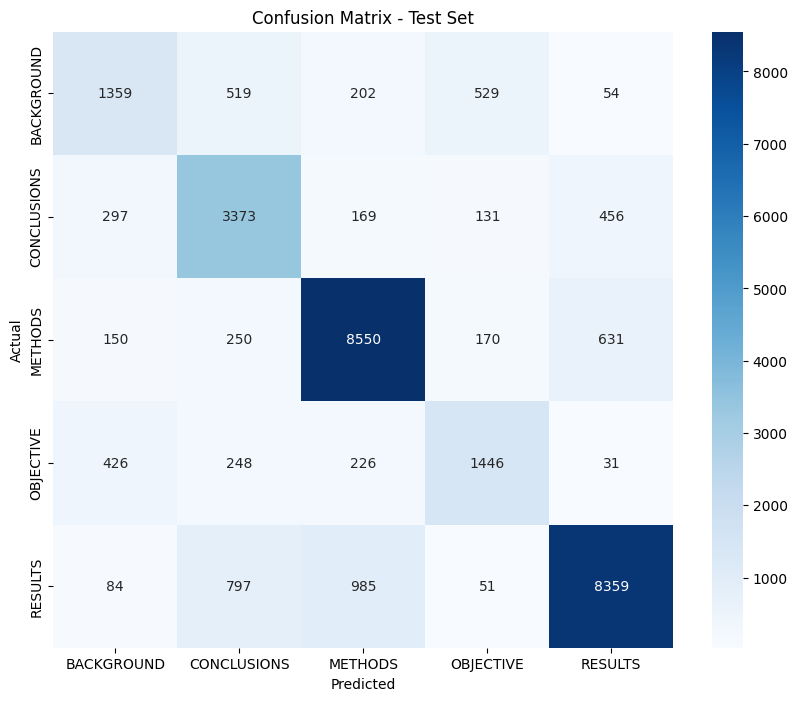

In [ ]:
# Confusion Matrix on test set
if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred)

    cm_df = pd.DataFrame(
        cm,
        index=[f"True: {cls}" for cls in target_names],
        columns=[f"Pred: {cls}" for cls in target_names]
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Test Set')
    plt.show()

# **Part B**
TF-IDF score based Classifier

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")


print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)
if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
    pass
else:
    print("Initial model evaluation skipped: Predictions not available.")


param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.5, 1.0]
}

if len(X_dev) >= 2:
    grid = GridSearchCV(pipeline, param_grid, cv=2, scoring='f1_macro', n_jobs=-1, verbose=1)

    print("\nStarting Hyperparameter Tuning on Development Set...")
    grid.fit(X_dev, y_dev)
    print("Grid search complete.")
else:
    print("\nInsufficient development data for cross-validation. Skipping grid search.")
    grid = None


if grid is not None and hasattr(grid, 'best_params_'):
    print(f"\nBest parameters: {grid.best_params_}")
    print(f"Best cross-validation score: {grid.best_score_:.4f}")
    pass
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")


Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.7650
              precision    recall  f1-score   support

  BACKGROUND       0.67      0.39      0.49      2663
 CONCLUSIONS       0.65      0.70      0.67      4426
     METHODS       0.79      0.87      0.83      9751
   OBJECTIVE       0.73      0.41      0.53      2377
     RESULTS       0.81      0.87      0.84     10276

    accuracy                           0.76     29493
   macro avg       0.73      0.65      0.67     29493
weighted avg       0.76      0.76      0.75     29493

Macro-averaged F1 score: 0.6715

Starting Hyperparameter Tuning on Development Set...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Grid search complete.

Best parameters: {'nb__alpha': 0.5, 'tfidf__ngram_range': (1, 1)}
Best cross-validation score: 0.5210


# **Part C**
Bayes Optimal Classifier

Please enter your full SRN (e.g., PES1UG22CS345): PES2UG23CS151
My SRN isPES2UG23CS151
Using dynamic sample size: 10151
Actual sampled training set size used: 3
Using 3 samples for training base models.

=== Training Base Models (H1–H5) ===
Training NaiveBayes...
NaiveBayes trained successfully.
Training LogisticRegression...
LogisticRegression trained successfully.
Training RandomForest...
RandomForest trained successfully.
Training DecisionTree...
DecisionTree trained successfully.
Training KNN...
KNN trained successfully.

=== Evaluation of Individual Hypotheses on Test Set ===
NaiveBayes           | Accuracy: 0.5000 | F1 (macro): 0.3333
LogisticRegression   | Accuracy: 0.5000 | F1 (macro): 0.3333
RandomForest         | Accuracy: 0.5000 | F1 (macro): 0.3333
DecisionTree         | Accuracy: 0.5000 | F1 (macro): 0.3333
KNN                  | Accuracy: 0.5000 | F1 (macro): 0.3333

=== Training Voting Classifier (Bayes Optimal Approximation) ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Voting Classifier trained successfully.

=== Final Evaluation: Bayes Optimal Classifier Approximation ===
Accuracy: 0.5000
              precision    recall  f1-score   support

  BACKGROUND       0.50      1.00      0.67         1
 CONCLUSIONS       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

Macro F1 Score: 0.3333


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 2, does not match size of target_names, 5
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

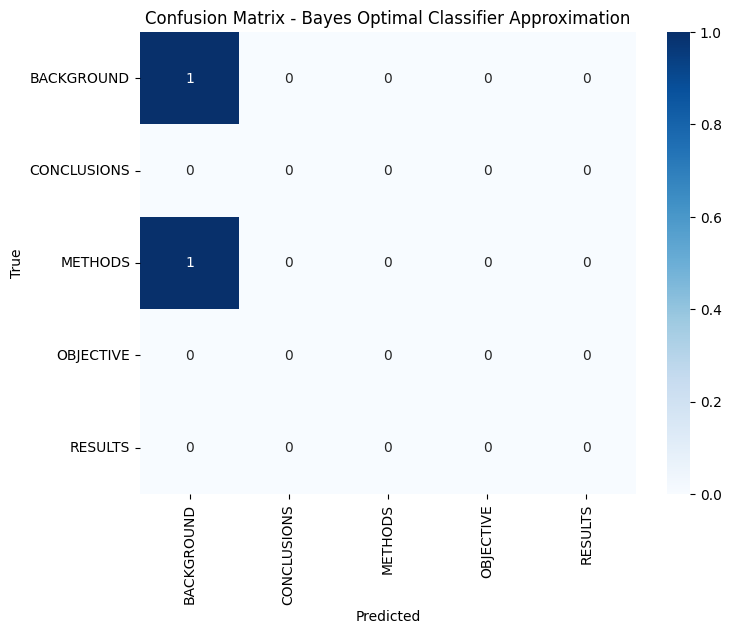

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# =======================================================
# TODO: Implement the following steps:
# 1. Define the five diverse hypothesis pipelines (H1 to H5) using TfidfVectorizer
#    and the specified classifiers (NB, LR, RF, DT, KNN).
# 2. Train each of the five hypotheses on the sampled training data.
# 3. Create a list of estimators for the VotingClassifier.
# 4. Initialize and fit the VotingClassifier (Bayes Optimal Classifier approximation).
# 5. Make final predictions and evaluate the BOC performance on the test data.
# =======================================================

# Sampling for faster training of multiple models (DO NOT CHANGE)
#
# *** STUDENT ACTION REQUIRED ***
# This section dynamically calculates the sample size based on the student's SRN.
# When running this cell, a prompt will appear asking for the full SRN.
#
BASE_SAMPLE_SIZE = 10000

FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")

try:
    if len(FULL_SRN) >= 3:
        print("My SRN is" + FULL_SRN)
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError):
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value

print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Assuming X_train and y_train were loaded in Part A
# Placeholder initialization in case data wasn't loaded in the environment
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one", "sample text two", "sample text three"])
    y_train = pd.Series(["BACKGROUND", "METHODS", "RESULTS"])
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = sorted(y_train.unique()) # Update target_names based on available training labels
    print(f"Classes: {target_names}")


# Create the sampled training subset
# Ensure SAMPLE_SIZE does not exceed the size of the actual training data
effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

print(f"Using {len(X_train_sampled)} samples for training base models.")

# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 0.0  # Adjusted min_df to handle very small sample sizes
}

# Define the five diverse hypotheses/pipelines

# Multinomial Naive Bayes
h1_nb = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', MultinomialNB(alpha=1.0, fit_prior=False))])

# Logistic Regression
h2_lr = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))])

# Random Forest Classifier
h3_rf = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1))])

# Decision Tree Classifier
h4_dt = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', DecisionTreeClassifier(max_depth=10, random_state=42))])

# K-Nearest Neighbors
h5_knn = Pipeline([('tfidf', TfidfVectorizer(**tfidf_params)),
                  ('clf', KNeighborsClassifier(n_neighbors=1, n_jobs=-1))]) # Changed n_neighbors to 1

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']


print("\n=== Training Base Models (H1–H5) ===")
for name, model in zip(hypothesis_names, hypotheses):
    print(f"Training {name}...")
    model.fit(X_train_sampled, y_train_sampled)
    print(f"{name} trained successfully.")

print("\n=== Evaluation of Individual Hypotheses on Test Set ===")
for name, model in zip(hypothesis_names, hypotheses):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"{name:20s} | Accuracy: {acc:.4f} | F1 (macro): {f1:.4f}")

estimators = [(name, model) for name, model in zip(hypothesis_names, hypotheses)]

voting_clf = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)
print("\n=== Training Voting Classifier (Bayes Optimal Approximation) ===")
voting_clf.fit(X_train_sampled, y_train_sampled)
print("Voting Classifier trained successfully.")

# Predict and evaluate
print("\n=== Final Evaluation: Bayes Optimal Classifier Approximation ===")
y_pred_voting = voting_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_voting):.4f}")
print(classification_report(y_test, y_pred_voting, target_names=target_names, labels=np.unique(y_test))) # Added labels parameter
print(f"Macro F1 Score: {f1_score(y_test, y_pred_voting, average='macro', labels=np.unique(y_test)):.4f}") # Added labels parameter

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_voting, labels=target_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Bayes Optimal Classifier Approximation")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [9]:
print("Training individual hypotheses...")
for hyp, name in zip(hypotheses, hypothesis_names):
    print(f"Training {name}...")
    hyp.fit(X_train_sampled, y_train_sampled)
print("All base models trained.")






Training individual hypotheses...
Training NaiveBayes...
Training LogisticRegression...
Training RandomForest...
Training DecisionTree...
Training KNN...
All base models trained.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [10]:
# List of (name, estimator) tuples for the VotingClassifier
estimators = list(zip(hypothesis_names, hypotheses))

# // TODO: Initialize the VotingClassifier using 'estimators'
boc_hard_voter = VotingClassifier(estimators=estimators, voting='hard', n_jobs=-1)

print("\nFitting the VotingClassifier (BOC approximation)...")
# // TODO: Fit the VotingClassifier using the sampled training data
boc_hard_voter.fit(X_train_sampled, y_train_sampled)

# // TODO: Predict y_boc_pred using X_test
y_boc_pred = boc_hard_voter.predict(X_test)



Fitting the VotingClassifier (BOC approximation)...


In [12]:
print("\n=== Final Evaluation: Bayes Optimal Classifier (Hard Voting) ===")

if y_boc_pred is not None:
    boc_accuracy = accuracy_score(y_test, y_boc_pred)
    boc_f1 = f1_score(y_test, y_boc_pred, average='macro', labels=np.unique(y_test))

    print(f"BOC Accuracy: {boc_accuracy:.4f}")
    print(f"BOC Macro F1 Score: {boc_f1:.4f}")
    print(classification_report(y_test, y_boc_pred, target_names=target_names, labels=np.unique(y_test)))
    pass


=== Final Evaluation: Bayes Optimal Classifier (Hard Voting) ===
BOC Accuracy: 0.5000
BOC Macro F1 Score: 0.3333
              precision    recall  f1-score   support

  BACKGROUND       0.50      1.00      0.67         1
 CONCLUSIONS       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 2, does not match size of target_names, 5
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

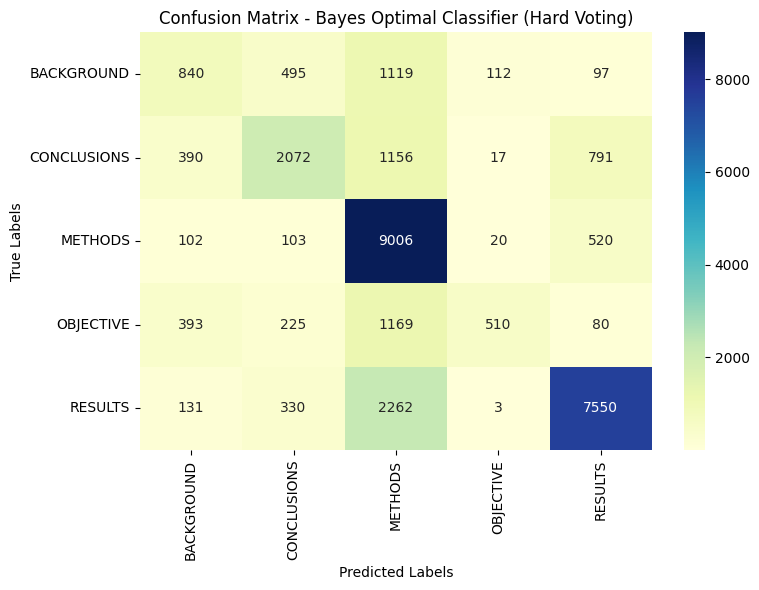

In [ ]:

if y_boc_pred is not None:
    cm = confusion_matrix(y_test, y_boc_pred, labels=target_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix - Bayes Optimal Classifier (Hard Voting)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix cannot be generated — predictions missing.")

Part C Draft


Calculating posterior weights based on validation likelihood...
Posterior Weights (P(h|D)):
NaiveBayes           -> 0.200
LogisticRegression   -> 0.200
RandomForest         -> 0.200
DecisionTree         -> 0.200
KNN                  -> 0.200

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.5000
Macro F1 Score: 0.3333

Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.50      1.00      0.67         1
 CONCLUSIONS       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 2, does not match size of target_names, 5
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

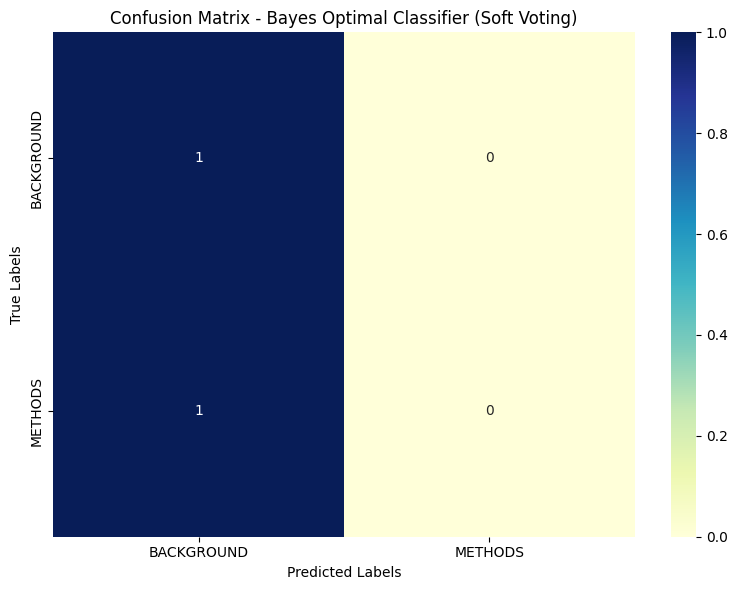

In [14]:
# This cell will now use the variables defined and models trained in the previous cell.
# The redundant code for sample size calculation and model training is removed.

# // TODO: Implement the Posterior Weight Calculation (P(h_i | D)).
# This requires splitting X_train_sampled into a small train_sub/val_sub set
# and calculating the validation log-likelihood for each model. Normalize these to get posterior_weights.

print("\nCalculating posterior weights based on validation likelihood...")

# Split into small validation subset
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=42
)

log_likelihoods = []

for name, model in zip(hypothesis_names, hypotheses):
    # For simplicity, using F1-macro as a proxy for model evidence likelihood on the validation subset
    y_val_pred = model.predict(X_val_sub)
    f1 = f1_score(y_val_sub, y_val_pred, average='macro')
    # Add a small offset before taking log to avoid log(0)
    log_likelihoods.append(np.log(f1 + 1e-6))

# Normalize log-likelihoods to get posterior weights
# Subtract max for numerical stability before exponentiating
exp_vals = np.exp(log_likelihoods - np.max(log_likelihoods))
posterior_weights = exp_vals / np.sum(exp_vals)

print("Posterior Weights (P(h|D)):")
for name, w in zip(hypothesis_names, posterior_weights):
    print(f"{name:20s} -> {w:.3f}")


# Implement and Evaluate the Bayes Optimal Classifier
estimators = list(zip(hypothesis_names, hypotheses))

# BOC is approximated using soft voting with posterior weights
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
# Fit the VotingClassifier using the full sampled training data (X_train_sampled, y_train_sampled)
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")


# Make the final BOC prediction on the test set
print("\nPredicting on test set...")
# Predict y_pred using X_test, and then calculate and visualize evaluation metrics.
y_pred = boc_soft_voter.predict(X_test)


# Final Evaluation
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")

if y_pred is not None:
    # Example calculations:
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro', labels=np.unique(y_test)) # Added labels parameter
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names, labels=np.unique(y_test))) # Added labels parameter

    # Generate and visualize the Confusion Matrix (heatmap) for the BOC predictions.
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test)) # Added labels parameter here
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test)) # Added xticklabels and yticklabels here
    plt.title("Confusion Matrix - Bayes Optimal Classifier (Soft Voting)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()
else:
    print("Evaluation skipped: Predictions not generated.")